In [1]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [2]:
btc = yf.Ticker('BTC-USD')
ltc = yf.Ticker('LTC-USD')
eth = yf.Ticker('ETH-USD')

btc_hist = btc.history(period='max')
ltc_hist = ltc.history(period='max')
eth_hist = eth.history(period='max')

In [3]:
btc_hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,21056800,0.0,0.0
2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,34483200,0.0,0.0
2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,37919700,0.0,0.0
2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,36863600,0.0,0.0
2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,26580100,0.0,0.0


In [4]:
btc_his_res = btc_hist.reset_index()[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
ltc_his_res = ltc_hist.reset_index()[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
eth_his_res = eth_hist.reset_index()[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]

In [5]:
def train_test_split(data, test_size=0.2):
    train_size = int(len(data) * (1 - test_size))
    train, test = data[:train_size], data[train_size:]
    return train, test

btc_train, btc_test = train_test_split(btc_his_res)
ltc_train, ltc_test = train_test_split(ltc_his_res)
eth_train, eth_test = train_test_split(eth_his_res)

<Axes: ylabel='Close'>

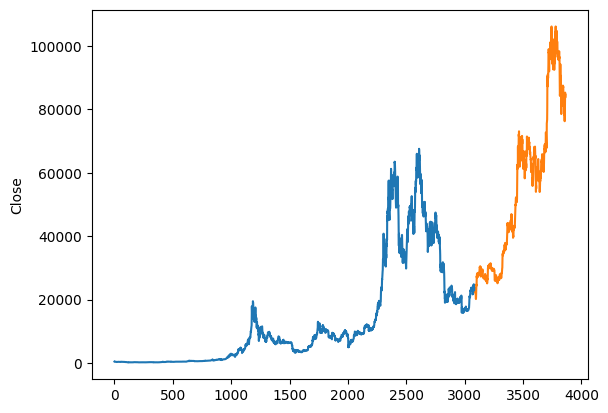

In [6]:
sns.lineplot(data=btc_train['Close'])
sns.lineplot(data=btc_test['Close'])

<Axes: ylabel='Close'>

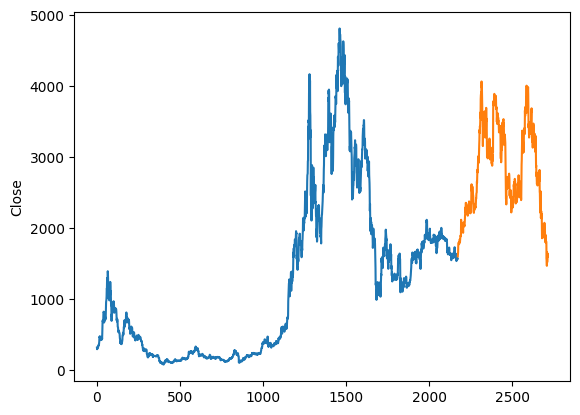

In [7]:
sns.lineplot(data=eth_train['Close'])
sns.lineplot(data=eth_test['Close'])

<Axes: ylabel='Close'>

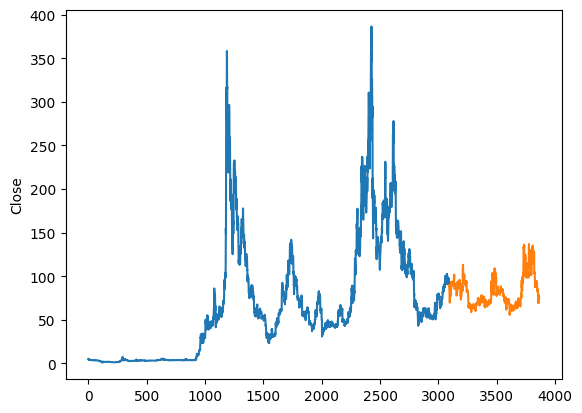

In [8]:
sns.lineplot(data=ltc_train['Close'])
sns.lineplot(data=ltc_test['Close'])

In [9]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i])
    return np.array(X), np.array(y)


In [10]:
def evaluate_model(y_true, y_pred, model_name='Model'):
    mse = mean_squared_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"{model_name} Evaluation")
    print(f"MSE : {mse}")
    print(f"RMSE: {rmse}")
    print(f"MAE : {mae}")
    print(f"R²  : {r2}")

## Bitcoin

In [11]:
btc_close_train = btc_train['Close'].values.reshape(-1, 1)
btc_close_test = btc_test['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler()
btc_scaled_train = scaler.fit_transform(btc_close_train)
btc_scaled_test = scaler.transform(btc_close_test)

In [12]:
seq_length = 60
X_train, y_train = create_sequences(btc_scaled_train, seq_length)
X_test, y_test = create_sequences(btc_scaled_test, seq_length)

In [13]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3030, 60, 1), (3030, 1), (713, 60, 1), (713, 1))

In [14]:
window_size = 60
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(window_size, 1)),
    Dropout(0.2),
    LSTM(128, return_sequences=False),
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

In [15]:
history_btc = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

Epoch 1/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0110 - val_loss: 8.9317e-04
Epoch 2/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 8.0891e-04 - val_loss: 6.4205e-04
Epoch 3/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 6.9972e-04 - val_loss: 0.0012
Epoch 4/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 6.2370e-04 - val_loss: 4.9170e-04
Epoch 5/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 5.8475e-04 - val_loss: 6.8573e-04
Epoch 6/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 5.4779e-04 - val_loss: 4.9349e-04
Epoch 7/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 4.4615e-04 - val_loss: 4.3967e-04
Epoch 8/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 5.2116e-04 - val_loss: 4.1971e-04
Epoch 9/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 6.1393e-04 - val_loss: 3.1299e-04
Epoch 10/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 3.7476e-04 - val_loss: 6.0185e-04
Epoch 11/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 4.4735e-04 - val_

In [16]:
predicted = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test)
evaluate_model(y_test, predicted, 'Bitcoin Model')

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Bitcoin Model Evaluation
MSE : 0.0012247717457027087
RMSE: 0.03499673907241514
MAE : 0.028679886007488355
R²  : 0.9903587148778922


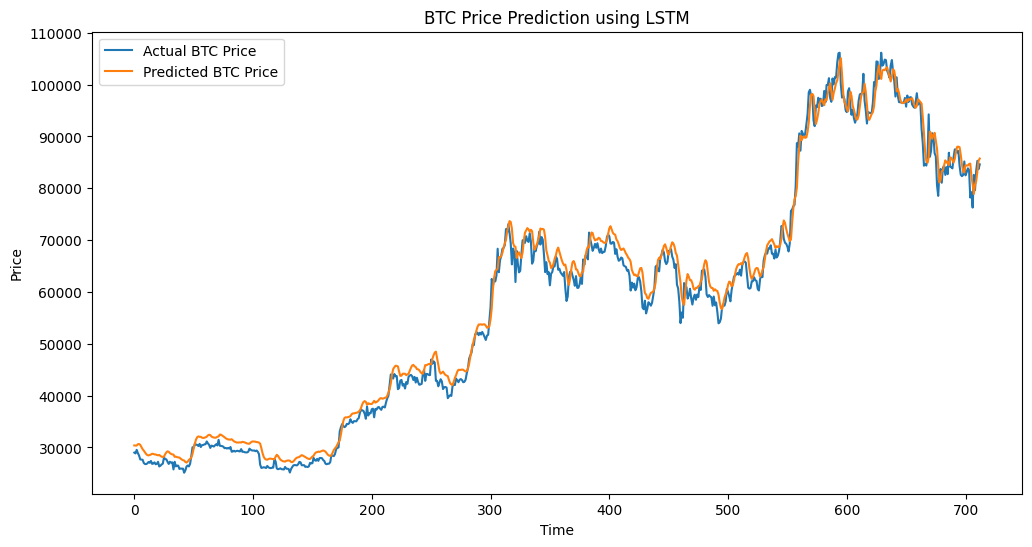

In [17]:
plt.figure(figsize=(12,6))
plt.plot(real_prices, label="Actual BTC Price")
plt.plot(predicted_prices, label="Predicted BTC Price")
plt.title("BTC Price Prediction using LSTM")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

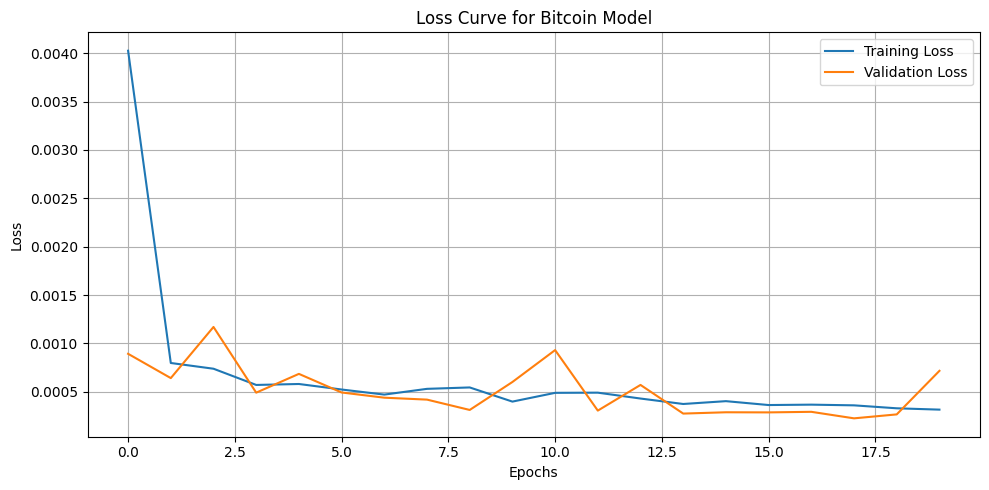

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(history_btc.history['loss'], label='Training Loss')
plt.plot(history_btc.history['val_loss'], label='Validation Loss')
plt.title(f'Loss Curve for Bitcoin Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Ethereum

In [19]:
eth_close_train = eth_train['Close'].values.reshape(-1, 1)
eth_close_test = eth_test['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler()
eth_scaled_train = scaler.fit_transform(eth_close_train)
eth_scaled_test = scaler.transform(eth_close_test)

In [20]:
seq_length = 60
X_train, y_train = create_sequences(eth_scaled_train, seq_length)
X_test, y_test = create_sequences(eth_scaled_test, seq_length)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2111, 60, 1), (2111, 1), (483, 60, 1), (483, 1))

In [21]:
window_size = 60
model_eth = Sequential([
    LSTM(128, return_sequences=True, input_shape=(window_size, 1)),
    Dropout(0.2),
    LSTM(128, return_sequences=False),
    Dense(units=1)
])

model_eth.compile(optimizer='adam', loss='mean_squared_error')

In [22]:
history_eth = model_eth.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0270 - val_loss: 2.9963e-04
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0015 - val_loss: 1.8629e-04
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0012 - val_loss: 8.5058e-04
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0013 - val_loss: 2.4043e-04
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0011 - val_loss: 1.7561e-04
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0010 - val_loss: 1.7491e-04
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0010 - val_loss: 1.5251e-04
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0010 - val_loss: 1.9552e-04
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 8.8263e-04 - val_loss: 1.5422e-04
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 7.5446e-04 - val_loss: 2.9226e-04
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0010 - val_loss: 2.2455e-04
Epoch 12/20

In [23]:
predicted = model_eth.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test)
evaluate_model(y_test, predicted, 'Ethereum Model')

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Ethereum Model Evaluation
MSE : 0.0008293994697571664
RMSE: 0.028799296341354703
MAE : 0.021389851593888155
R²  : 0.9449478527296851


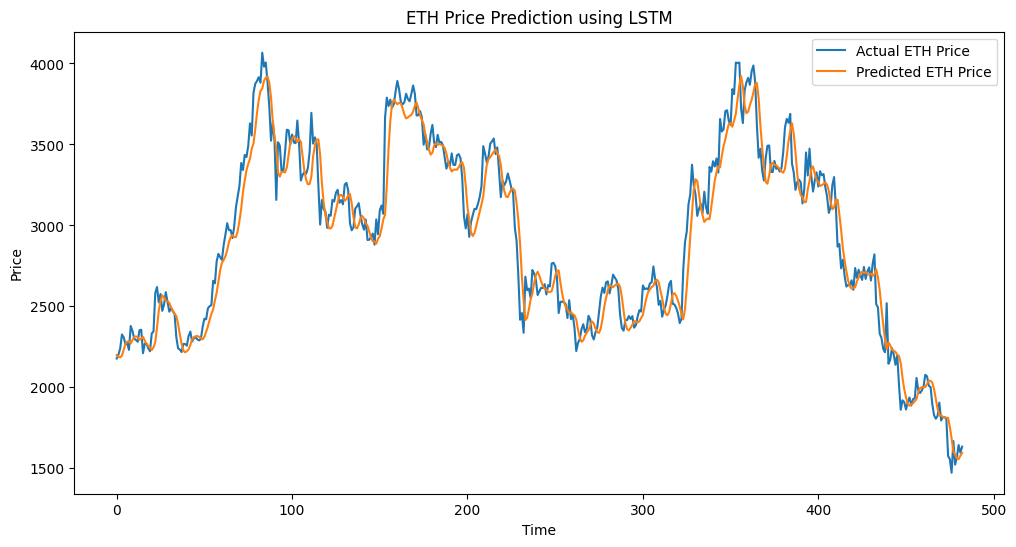

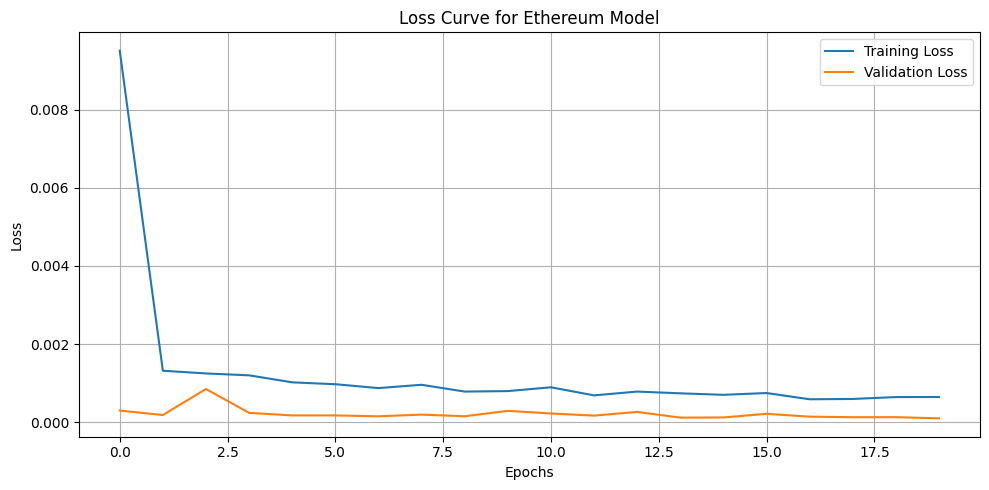

In [24]:
plt.figure(figsize=(12,6))
plt.plot(real_prices, label="Actual ETH Price")
plt.plot(predicted_prices, label="Predicted ETH Price")
plt.title("ETH Price Prediction using LSTM")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.figure(figsize=(10, 5))
plt.plot(history_eth.history['loss'], label='Training Loss')
plt.plot(history_eth.history['val_loss'], label='Validation Loss')
plt.title(f'Loss Curve for Ethereum Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Litecoin

In [25]:
ltc_close_train = ltc_train['Close'].values.reshape(-1, 1)
ltc_close_test = ltc_test['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler()
ltc_scaled_train = scaler.fit_transform(ltc_close_train)
ltc_scaled_test = scaler.transform(ltc_close_test)

In [26]:
seq_length = 60
X_train, y_train = create_sequences(ltc_scaled_train, seq_length)
X_test, y_test = create_sequences(ltc_scaled_test, seq_length)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3030, 60, 1), (3030, 1), (713, 60, 1), (713, 1))

In [27]:
window_size = 60
model_ltc = Sequential([
    LSTM(128, return_sequences=True, input_shape=(window_size, 1)),
    Dropout(0.2),
    LSTM(128, return_sequences=False),
    Dense(units=1)
])

model_ltc.compile(optimizer='adam', loss='mean_squared_error')

In [28]:
history_ltc = model_ltc.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

Epoch 1/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0088 - val_loss: 3.7908e-04
Epoch 2/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0016 - val_loss: 3.0532e-04
Epoch 3/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0011 - val_loss: 1.4165e-04
Epoch 4/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 7.8115e-04 - val_loss: 1.9599e-04
Epoch 5/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 7.3978e-04 - val_loss: 1.2272e-04
Epoch 6/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 8.5294e-04 - val_loss: 1.5396e-04
Epoch 7/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 6.0248e-04 - val_loss: 1.3734e-04
Epoch 8/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 7.5767e-04 - val_loss: 1.0802e-04
Epoch 9/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 5.7618e-04 - val_loss: 1.2415e-04
Epoch 10/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 6.0034e-04 - val_loss: 1.5038e-04
Epoch 11/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 5.2629e-04 - val_loss

In [29]:
predicted = model_ltc.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test)
evaluate_model(y_test, predicted, 'Litcoin Model')

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Litcoin Model Evaluation
MSE : 0.00013170155508232916
RMSE: 0.011476129795463676
MAE : 0.007656442650385521
R²  : 0.9362508025402831


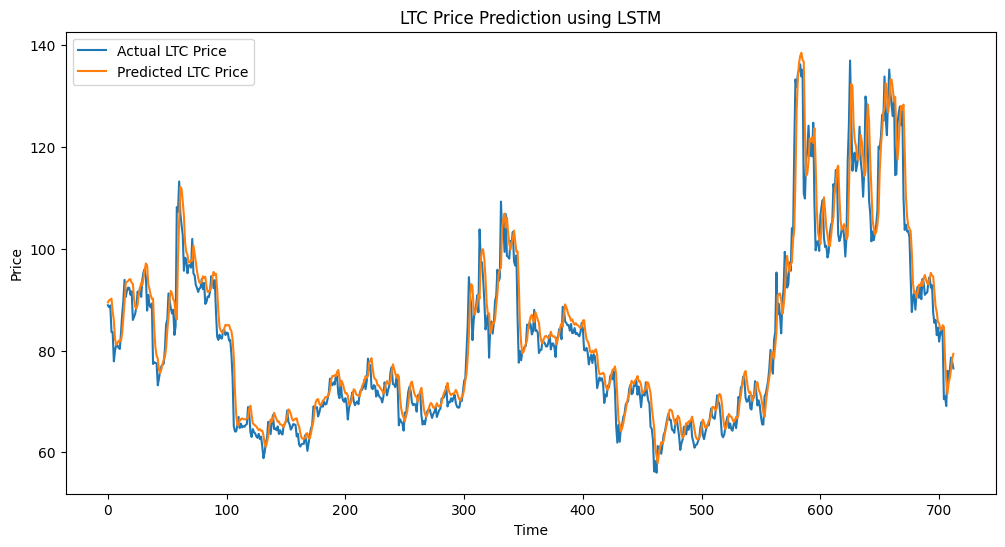

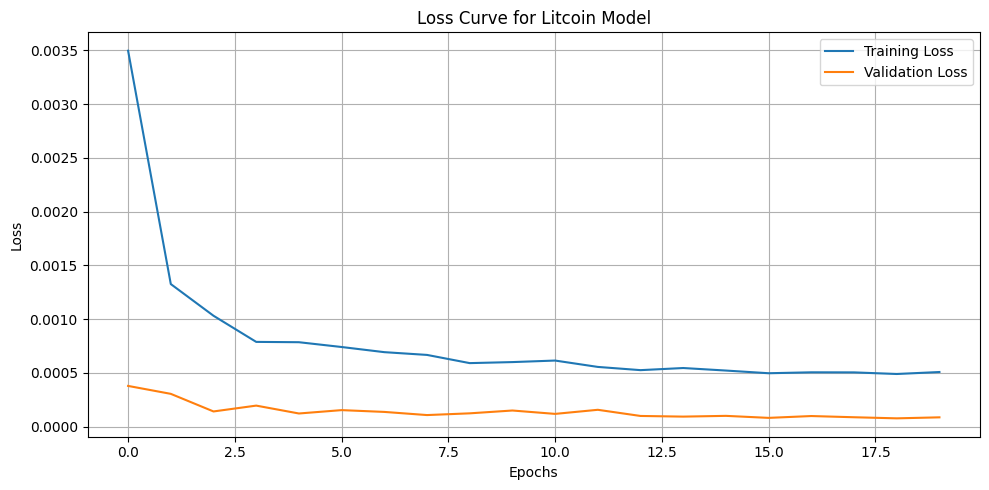

In [30]:
plt.figure(figsize=(12,6))
plt.plot(real_prices, label="Actual LTC Price")
plt.plot(predicted_prices, label="Predicted LTC Price")
plt.title("LTC Price Prediction using LSTM")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.figure(figsize=(10, 5))
plt.plot(history_ltc.history['loss'], label='Training Loss')
plt.plot(history_ltc.history['val_loss'], label='Validation Loss')
plt.title(f'Loss Curve for Litcoin Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Comparing the metrics of different coin model
Comparison within coin models <br>
Based on the evaluation metrics the following observations can be made 
- MSE : Litcoin model 
- RMSE: Litcoin model 
- MAE : Litcoin model 
- R²  : Bitcoin model 


Comparisom of individual models with multi-coin approach 
- Individual models perform better than multi-coin approach based off the evaluation metrics
- Individual models have higher R2 score than the mutli-coin approach 

